In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import toml

from modules.plot import get_colorbar_figure, scatter_with_score_rank_color, plot_kde_and_true_2dnormal
from modules.plot import merge_line_legends
from modules.utils import load, order
from tasks.experiment import Cleansing
from tasks.totaling import EvalCleansing, TotalizeCleansingWrtEval

sns.set()
sns.set_style('ticks')

TensorFlow version 1.15.3 has been patched using tfdeterminism version 0.3.0


In [2]:
out_dir = 'results/'
os.makedirs(out_dir, exist_ok=True)

In [3]:
# visual settings
d_metric_printedname = dict((
    ('log_likelihood_kde', 'Influence on ALL (Ours)'),
    ('loss_d', 'Influence on Disc. Loss'),
    ('if_data', 'Isolation Forest'),
    ('random', 'Random'),
    ))

ext_savefig = 'png'
kwargs_savefig = {'dpi': 300}

path_conf = 'conf/2d_cleansing.toml'

idx_removal_rate = 3 # 5k

first_nseeds = 5
nlevels_contour = 8

labels = ['True', 'No removal', 'Cleansed']

xlim = (-3.7546138096179362, 5.864293814755581)
ylim = (-3.75398701722154, 6.003643363421571)

In [4]:
# load configs 
conf = toml.load(open(path_conf, 'r'))[TotalizeCleansingWrtEval.__name__]

conf_popped = {
    'seeds': conf.pop('seeds'),
    'removal_rates': conf.pop('removal_rates'),
    'metrics': conf.pop('metrics'),
    'eval_metrics': conf.pop('eval_metrics')
}

metrics = conf_popped['metrics']

# get intermediate files of instance scoring before the cleansing by changing selection metric
d_metric_clean_dir = {
    metric: Cleansing(
        **conf,
        seed=conf_popped['seeds'][0],
        metric=metric,
        removal_rate=conf_popped['removal_rates'][idx_removal_rate]
    ).output().path for metric in metrics
}

# get intermediate files of test GAN evaluation metrics after the cleansing by changing selection metric
d_metric_eval_dir = {
    metric: EvalCleansing(
        **conf,
        seed=conf_popped['seeds'][0],
        metric=metric,
        eval_metric=conf_popped['eval_metrics'][0],
        removal_rate=conf_popped['removal_rates'][idx_removal_rate]
    ).output().path for metric in metrics
}


seeds = conf_popped['seeds'][:first_nseeds]

d_seed_clean_dir = {
    seed: Cleansing(
        **conf,
        seed=seed,
        metric=conf_popped['metrics'][0],
        removal_rate=conf_popped['removal_rates'][idx_removal_rate]
    ).output().path for seed in seeds
}

d_seed_eval_dir = {
    seed: EvalCleansing(
        **conf,
        seed=seed,
        metric=conf_popped['metrics'][0],
        eval_metric=conf_popped['eval_metrics'][0],
        removal_rate=conf_popped['removal_rates'][idx_removal_rate]
    ).output().path for seed in seeds
}


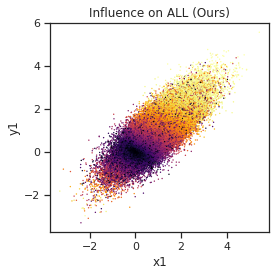

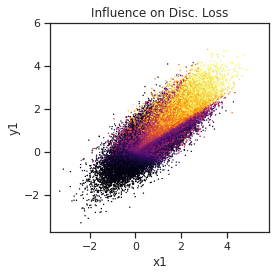

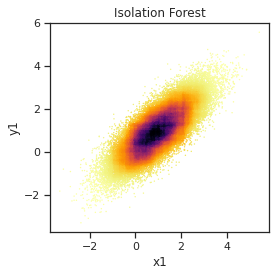

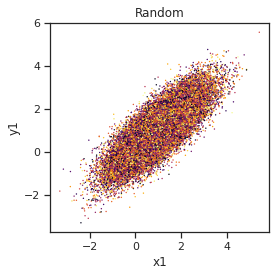

In [5]:
# plot scatter of training instances colored based on harmful score ranking, w.r.t selection method
# these results can be loaded only after finishing the experiment command written in "Experiment 2: Data Cleansing" of README.md

for metric in metrics:
    x = load(os.path.join(d_metric_clean_dir[metric], f'x.pkl'))
    harmful_scores = load(os.path.join(d_metric_clean_dir[metric], f'harmful_scores.pkl'))
    fig, ax = scatter_with_score_rank_color(x, harmful_scores)
    ax.set_title(d_metric_printedname[metric])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    fig.tight_layout()
    basename = f'2d_harmers_{metric}.{ext_savefig}'
    fig.savefig(os.path.join(out_dir, basename), **kwargs_savefig)

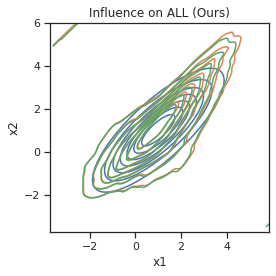

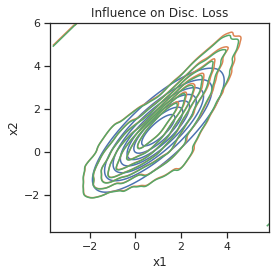

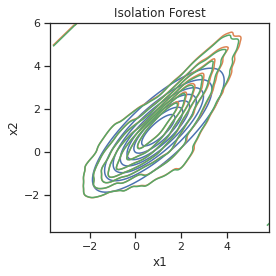

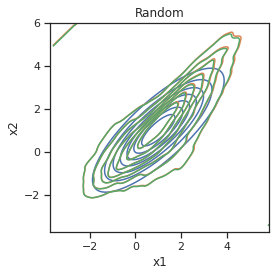

In [6]:
# plot generated instances before and after the data cleansing with true 2d-normal distribution. w.r.t selection method
for i, metric in enumerate(metrics):
    df_clean = load(os.path.join(d_metric_eval_dir[metric], f'df_clean.pkl'))
    df_ori = load(os.path.join(d_metric_eval_dir[metric], f'df_ori.pkl'))
    df_concat = pd.concat([df_ori, df_clean], axis=0)
    fig, ax = plot_kde_and_true_2dnormal(x='x',
                                        y='y',
                                        data=df_concat,
                                        hue='data',
                                        nlevels_contour=nlevels_contour,
                                        figsize=(4, 4),
                                        mean=[1., 1.],
                                        cov=[[1., 0.8], [0.8, 1.]],
                                        idx_color_true=0,
                                        idxs_color_other=[1, 2])
    ax.set_title(d_metric_printedname[metric])
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    fig.tight_layout()
    basename = f'2d_improves_{metric}.{ext_savefig}'
    fig.savefig(os.path.join(out_dir, basename), **kwargs_savefig)

In [7]:
# amount of improvements by the data cleansing used for a table in the latex source
for i, metric in enumerate(metrics):
    result = load(os.path.join(d_metric_eval_dir[metric], f'result.pkl'))
    val = result["metric_cleansed"] - result["metric_no_removal"]
    print(f'{{{metric}}}{{{d_metric_printedname[metric]}}}{{{val * 100:+.2f}}}')

{log_likelihood_kde}{Influence on ALL (Ours)}{+1.24}
{loss_d}{Influence on Disc. Loss}{+0.67}
{if_data}{Isolation Forest}{+0.73}
{random}{Random}{+0.43}


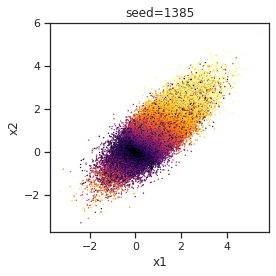

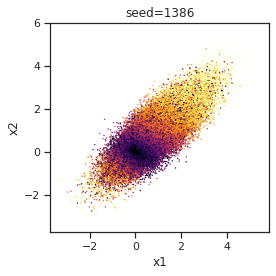

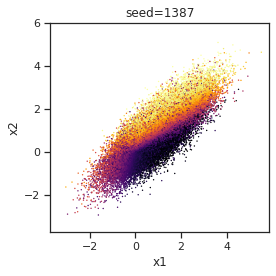

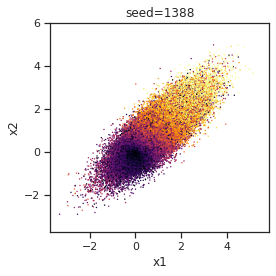

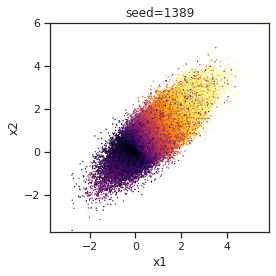

In [8]:
# plot scatter of training instances colored based on harmful score ranking, w.r.t random seed
for seed in seeds:
    x = load(os.path.join(d_seed_clean_dir[seed], f'x.pkl'))
    harmful_scores = load(os.path.join(d_seed_clean_dir[seed], f'harmful_scores.pkl'))
    fig, ax = scatter_with_score_rank_color(x, harmful_scores)
    ax.set_title(f'seed={seed}')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    fig.tight_layout()
    basename = f'2d_harmers_{seed}.{ext_savefig}'
    fig.savefig(os.path.join(out_dir, basename), **kwargs_savefig)

In [ ]:
# plot generated instances before and after the data cleansing with true 2d-normal distribution.
for i, seed in enumerate(seeds):
    df_clean = load(os.path.join(d_seed_eval_dir[seed], f'df_clean.pkl'))
    df_ori = load(os.path.join(d_seed_eval_dir[seed], f'df_ori.pkl'))
    df_concat = pd.concat([df_ori, df_clean], axis=0)
    fig, _ = plot_kde_and_true_2dnormal(x='x',
                                        y='y',
                                        data=df_concat,
                                        hue='data',
                                        nlevels_contour=nlevels_contour,
                                        figsize=(4, 4),
                                        mean=[1., 1.],
                                        cov=[[1., 0.8], [0.8, 1.]],
                                        idx_color_true=0,
                                        idxs_color_other=[1, 2])
    ax.set_title(f'seed={seed}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    fig.tight_layout()
    basename = f'2d_improves_{seed}.{ext_savefig}'
    fig.savefig(os.path.join(out_dir, basename), **kwargs_savefig)


In [ ]:
# amount of improvements by the data cleansing used for a table in the latex source
for i, seed in enumerate(seeds):
    result = load(os.path.join(d_seed_eval_dir[seed], f'result.pkl'))
    val = result["metric_cleansed"] - result["metric_no_removal"]
    print(f'{{{seed}}}{{{order(i+1)} random seed.}}{{{val*100:+.2f}}}')


In [ ]:
# collect lines to make one legend figure
## make dummy plot for get legends
labels = ['True', 'No removal', 'Cleansed']
fig_legend, ax_legend = plt.subplots()
for label in labels:
    ax_legend.plot(range(10), np.random.randn(10), label=label)

merge_line_legends(
    figs=[fig_legend],
    line_names=labels,
    out_path=os.path.join(out_dir, f'legend_2d.{ext_savefig}'),
)


In [ ]:
# make legend for the color bar of the harmfulness scatter figure

fig_colorbar, _ = get_colorbar_figure((4, 2), [0.05, 0.80, 0.9, 0.15])
fig_colorbar.savefig(os.path.join(out_dir, f'colarbar_2d.{ext_savefig}'), **kwargs_savefig)
